In [401]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, classification_report

# EDA

In [402]:
data = pd.read_csv('/kaggle/input/crops-data/data.csv')
print(data.columns)
submission = data[data['dataset'] == 'test']
data  = data[data['dataset'] == 'train']
data.drop('dataset', axis = 1, inplace=True)
submission.drop(['dataset', 'category'], axis = 1, inplace=True)
print(len(data), 'records')
print(data.info())

Index(['FarmID', 'category', 'Crop', 'State', 'District', 'Sub-District',
       'SDate', 'HDate', 'CropCoveredArea', 'CHeight', 'CNext', 'CLast',
       'CTransp', 'IrriType', 'IrriSource', 'IrriCount', 'WaterCov',
       'ExpYield', 'Season', 'geometry', 'dataset', 'tif_path', 'ndvi', 'evi',
       'ndwi', 'gndvi', 'savi', 'msavi'],
      dtype='object')
8775 records
<class 'pandas.core.frame.DataFrame'>
Index: 8775 entries, 0 to 8774
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           8775 non-null   int64  
 1   category         8775 non-null   object 
 2   Crop             8775 non-null   object 
 3   State            8775 non-null   object 
 4   District         8775 non-null   object 
 5   Sub-District     8775 non-null   object 
 6   SDate            8775 non-null   object 
 7   HDate            8775 non-null   object 
 8   CropCoveredArea  8775 non-null   int64  
 9   CHeight        

In [403]:
data.describe()

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,FarmID,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,evi,ndwi,gndvi,savi,msavi
count,8.775000e+03,8775.000000,8775.000000,8775.000000,8775.000000,8775.000000,7871.000000,7880.000000,7871.000000,7871.000000,7880.000000,7880.000000
mean,1.252339e+06,76.553504,87.707806,3.550541,57.150199,15.541197,0.690851,inf,10.217254,0.294307,1.025520,3840.883947
std,2.447332e+05,15.002601,49.307300,1.391602,22.330291,5.933997,1.678219,NaN,2.766826,0.895176,2.503108,1506.445228
min,2.780000e+02,40.000000,20.000000,1.000000,20.000000,5.000000,0.004725,-1479.291647,0.006600,0.003807,0.000000,0.000000
25%,1.314020e+06,65.000000,57.000000,2.000000,42.000000,11.000000,0.122129,-0.966054,9.438902,0.101975,0.180700,3045.733887
50%,1.324434e+06,78.000000,76.000000,4.000000,51.000000,15.000000,0.182504,0.694472,10.917676,0.168456,0.272113,3454.466187
75%,1.329228e+06,89.000000,100.000000,5.000000,82.000000,20.000000,0.260822,2.990868,11.946357,0.215787,0.388783,3963.734314
max,1.332157e+06,100.000000,250.000000,6.000000,100.000000,30.000000,18.339667,inf,16.823843,15.784201,27.505635,12733.712891


In [404]:
for col in data.select_dtypes(include=['object']):
    print(f"\nValue counts for {col}:\n")
    print(data[col].value_counts())


Value counts for category:

category
Healthy     7214
Diseased     537
Pests        536
Stressed     488
Name: count, dtype: int64

Value counts for Crop:

Crop
Paddy          2434
Cotton         1819
Maize          1506
Chillies       1063
Bengal Gram     938
Groundnut       768
Red Gram        247
Name: count, dtype: int64

Value counts for State:

State
Telangana    8775
Name: count, dtype: int64

Value counts for District:

District
Mahabubabad     1943
Adilabad        1909
Nalgonda        1408
Medak           1285
Nirmal          1254
Mahabubnagar     655
Narayanpet       203
Nagarkurnool      47
Warangal          30
Siddipet          14
Vikarabad         11
Kamareddy          7
Wanaparthy         6
Khammam            3
Name: count, dtype: int64

Value counts for Sub-District:

Sub-District
Utnur            506
Inderavelly      345
Gudur            338
Havelighanpur    305
Ramayampet       293
                ... 
Devarkadra         3
Singareni          2
Narsapur           2
Pem

In [405]:
data.drop(['tif_path','FarmID', 'State', 'geometry', 'District', 'Sub-District', 'Season'], axis=1, inplace=True)
submission.drop(['tif_path', 'State', 'geometry', 'District', 'Sub-District', 'Season'], axis=1, inplace=True)

In [406]:
def plotNumericalDistributionOnTopOfEachOther(train: pd.DataFrame, test: pd.DataFrame, numerical_cols: list):
    
    train_copy = train[numerical_cols].copy()
    test_copy = test[numerical_cols].copy()
    train_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

    ncols = 5
    num_cols = len(numerical_cols)
    nrows = math.ceil(num_cols / ncols)  
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), facecolor='#EAEAF2')
    fig.tight_layout(pad=3.0)  

    if nrows == 1:
        axes = [axes]  # Wrap the axes object in a list to handle the single-row case

    for r in range(nrows):
        for c in range(ncols):
            idx = r * ncols + c  # Calculate the corresponding index for the numerical column
            if idx < num_cols:
                col = numerical_cols[idx]
                ax = axes[r][c]  # Access the subplot using two indices

                sns.histplot(x=train_copy[col], ax=ax, color='#58D68D', label='Train data', fill=True, kde=True)

                if col in test_copy.columns:  # Check if the column exists in the test data copy
                    sns.histplot(x=test_copy[col], ax=ax, color='#DE3163', label='Test data', fill=True, kde=True)

                ax.legend()
                ax.set_ylabel('')
                ax.set_xlabel(col, fontsize=12)
                ax.tick_params(labelsize=10, width=0.5)
                ax.xaxis.offsetText.set_fontsize(8)
                ax.yaxis.offsetText.set_fontsize(8)
            else:
                fig.delaxes(axes[r][c])  # Remove unused subplot

    plt.show()


In [407]:
id_col = 'FarmID'
target_col = 'category'
drop_cols = ['geometry', 'State', 'Sub-District', 'tif_path', 'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi']
date_cols = [col for col in data.columns if 'Date' in col]
categorical_cols = [col for col in data.columns if data[col].dtype == 'object' and col not in date_cols + [id_col, target_col] + drop_cols]
numerical_cols = [col for col in data.columns if data[col].dtype != 'object' and col not in [id_col] + drop_cols]
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['Crop', 'CNext', 'CLast', 'CTransp', 'IrriType', 'IrriSource']
Numerical columns: ['CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield']


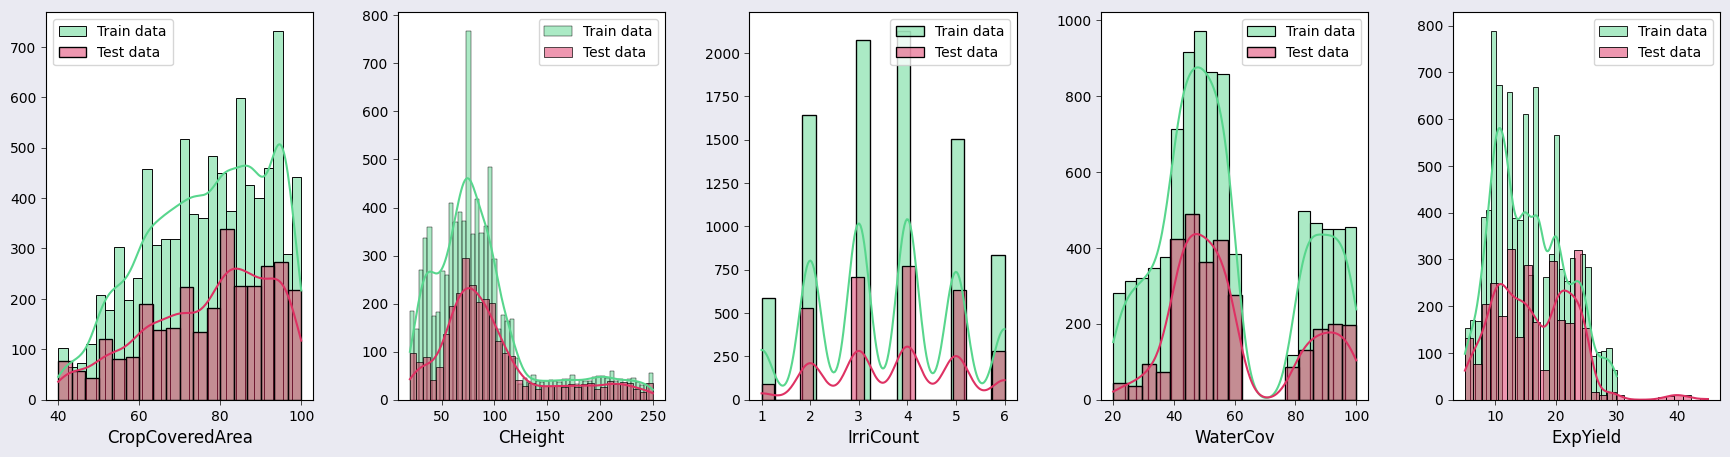

In [408]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plotNumericalDistributionOnTopOfEachOther(data, submission, numerical_cols)

* Numerical train and test data come from the same distributions
* CHeight is right skeweed  
We will apply **Log Transformation** to handle right skewness.

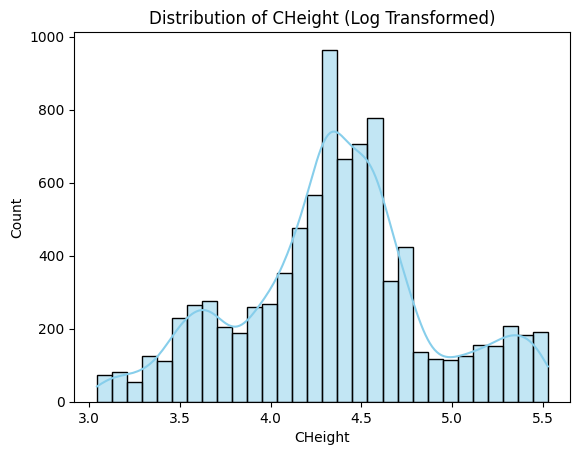

In [409]:
data['CHeight'] = np.log1p(data['CHeight'])
submission['CHeight'] = np.log1p(submission['CHeight'])
sns.histplot(data['CHeight'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of CHeight (Log Transformed)')
plt.show()

# Feature Engineering 
> **ndvi, evi, ndwi, gndvi, savi, and msavi** features were all calculated previously using the Sentinel-2 images then added manually to the used csv.

In [410]:
data['crop_last_current__next'] = data['CLast'] + "_" + data['Crop'] + '_' + data['CNext']
submission['crop_last_current__next'] = submission['CLast'] + "_" + submission['Crop'] + '_'+ submission['CNext']
data.drop(['CNext', 'Crop', 'CLast'], axis=1, inplace = True)
submission.drop(['CNext', 'Crop', 'CLast'], axis=1, inplace = True)

In [411]:
data['SDate'] = pd.to_datetime(data['SDate'],dayfirst=True)
data['HDate'] = pd.to_datetime(data['HDate'], dayfirst=True)
data['Duration'] = (data['HDate'] - data['SDate']).dt.days

submission['SDate'] = pd.to_datetime(submission['SDate'],dayfirst=True)
submission['HDate'] = pd.to_datetime(submission['HDate'], dayfirst=True)
submission['Duration'] = (submission['HDate'] - submission['SDate']).dt.days

# Dates Validity
886 Records have invalid Sow and Harvest Dates.

In [412]:
print(len(data[data['Duration']<0]))
print(len(submission[submission['Duration']<0]))

886
297


In [413]:
# Keep only rows where 'Duration' is greater than or equal to 0
data = data[data['Duration'] >= 0]
submission = submission[submission['Duration'] >= 0]
print('Records after dropping records with invalid dates:', len(data))
print('Records after dropping records with invalid dates:', len(submission))

Records after dropping records with invalid dates: 7889
Records after dropping records with invalid dates: 2719


In [414]:
data.drop(['SDate','HDate'], axis=1, inplace=True)
submission.drop(['SDate','HDate'], axis=1, inplace=True)

# One-hot Encoding

In [415]:
numerical_features = data.select_dtypes(include=['int64', 'float64'])
categorical_features = data.select_dtypes(include=['object'])

submission_numerical_features = submission.drop(columns=['FarmID']).select_dtypes(include=['int64', 'float64'])
submission_categorical_features = submission.drop(columns=['FarmID']).select_dtypes(include=['object'])

In [416]:
data = pd.get_dummies(data, categorical_features.columns, drop_first=False)
submission = pd.get_dummies(submission, submission_categorical_features.columns, drop_first=False)

# Handling Problematic Values

In [417]:
print("Missing Values in 'data':")
print(data.isnull().sum()[data.isnull().sum() > 0].to_frame('Missing Values').sort_values('Missing Values', ascending=False))

print("\nMissing Values in 'submission':")
print(submission.isnull().sum()[submission.isnull().sum() > 0].to_frame('Missing Values').sort_values('Missing Values', ascending=False))

Missing Values in 'data':
       Missing Values
ndvi               18
ndwi               18
gndvi              18
evi                 9
savi                9
msavi               9

Missing Values in 'submission':
       Missing Values
ndvi                6
ndwi                6
gndvi               6
evi                 4
savi                4
msavi               4


In [418]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
columns_to_impute = ['ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi']
for col in columns_to_impute:
    data[col] = data[col].fillna(data[col].median())  

In [419]:
missing_percent = (submission.isnull().sum() / len(submission)) * 100
print(missing_percent[missing_percent > 0])

ndvi     0.220669
evi      0.147113
ndwi     0.220669
gndvi    0.220669
savi     0.147113
msavi    0.147113
dtype: float64


# Oversampling

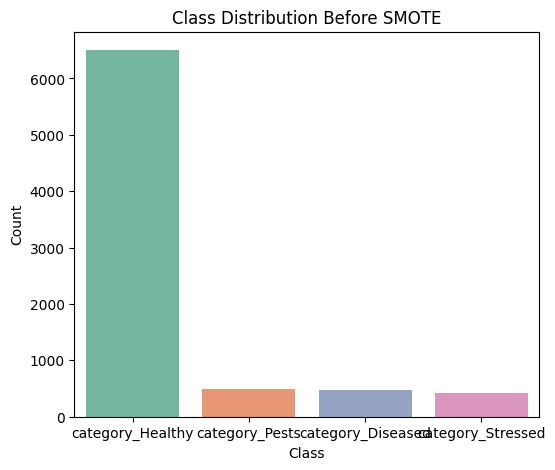

In [420]:
X = data.drop(columns=['category_Diseased', 'category_Healthy', 'category_Pests', 'category_Stressed'], axis=1)
y = data[['category_Diseased', 'category_Healthy', 'category_Pests', 'category_Stressed']].idxmax(axis=1)

original_class_counts = y.value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=original_class_counts.index, y=original_class_counts.values, palette='Set2')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

The data is highly imbalanced.

In [421]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['category'] = y_resampled

healthy_samples = 5000
diseased_samples = 2000
pests_samples = 2000
stressed_samples = 2000

class_counts = resampled_data['category'].value_counts()

healthy_data = resampled_data[resampled_data['category'] == 'category_Healthy']
diseased_data = resampled_data[resampled_data['category'] == 'category_Diseased']
pests_data = resampled_data[resampled_data['category'] == 'category_Pests']
stressed_data = resampled_data[resampled_data['category'] == 'category_Stressed']

# Resample each class to the desired number of samples
healthy_resampled = healthy_data.sample(n=healthy_samples, replace=True, random_state=42)
diseased_resampled = diseased_data.sample(n=diseased_samples, replace=True, random_state=42)
pests_resampled = pests_data.sample(n=pests_samples, replace=True, random_state=42)
stressed_resampled = stressed_data.sample(n=stressed_samples, replace=True, random_state=42)

balanced_data = pd.concat([healthy_resampled, diseased_resampled, pests_resampled, stressed_resampled])
resampled_class_counts = balanced_data['category'].value_counts()

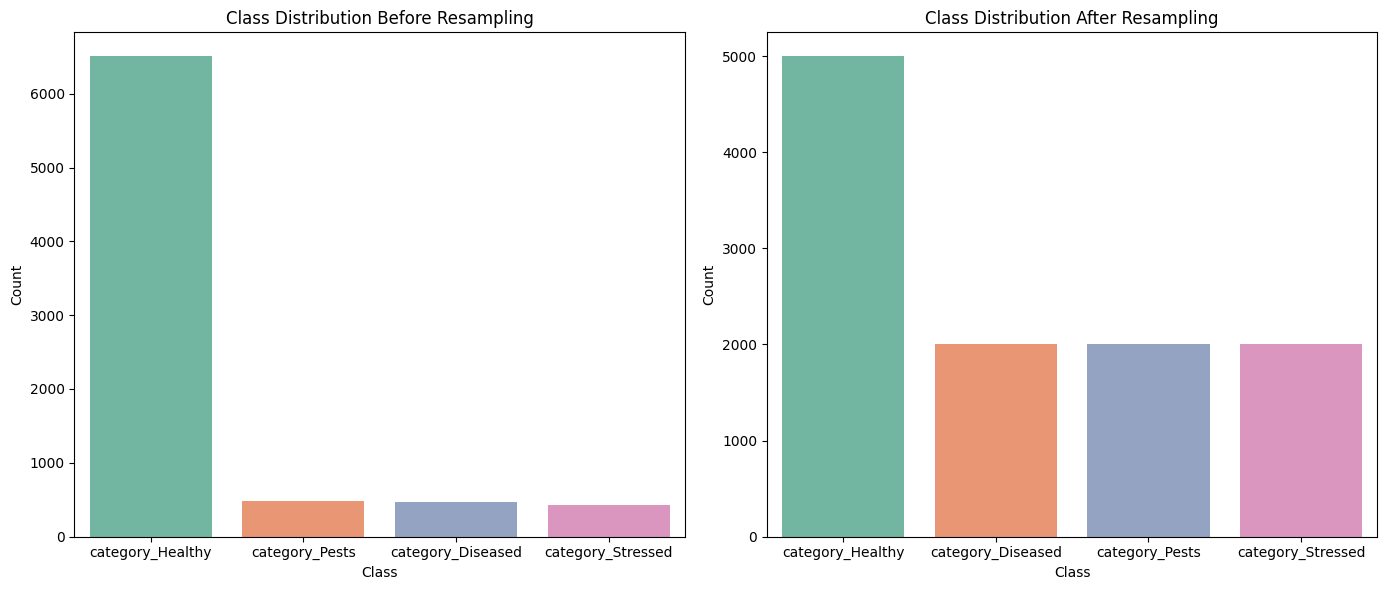

In [422]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=original_class_counts.index, y=original_class_counts.values, palette='Set2')
plt.title("Class Distribution Before Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.subplot(1, 2, 2)
sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, palette='Set2')
plt.title("Class Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Scaling

In [423]:
X_resampled = resampled_data.drop(columns=['category'])
y_resampled = resampled_data['category']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [424]:
scaler = StandardScaler()
X_train[numerical_features.columns] = scaler.fit_transform(X_train[numerical_features.columns])
X_test[numerical_features.columns] = scaler.transform(X_test[numerical_features.columns])

# Feature Importance using RandomForest

In [425]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

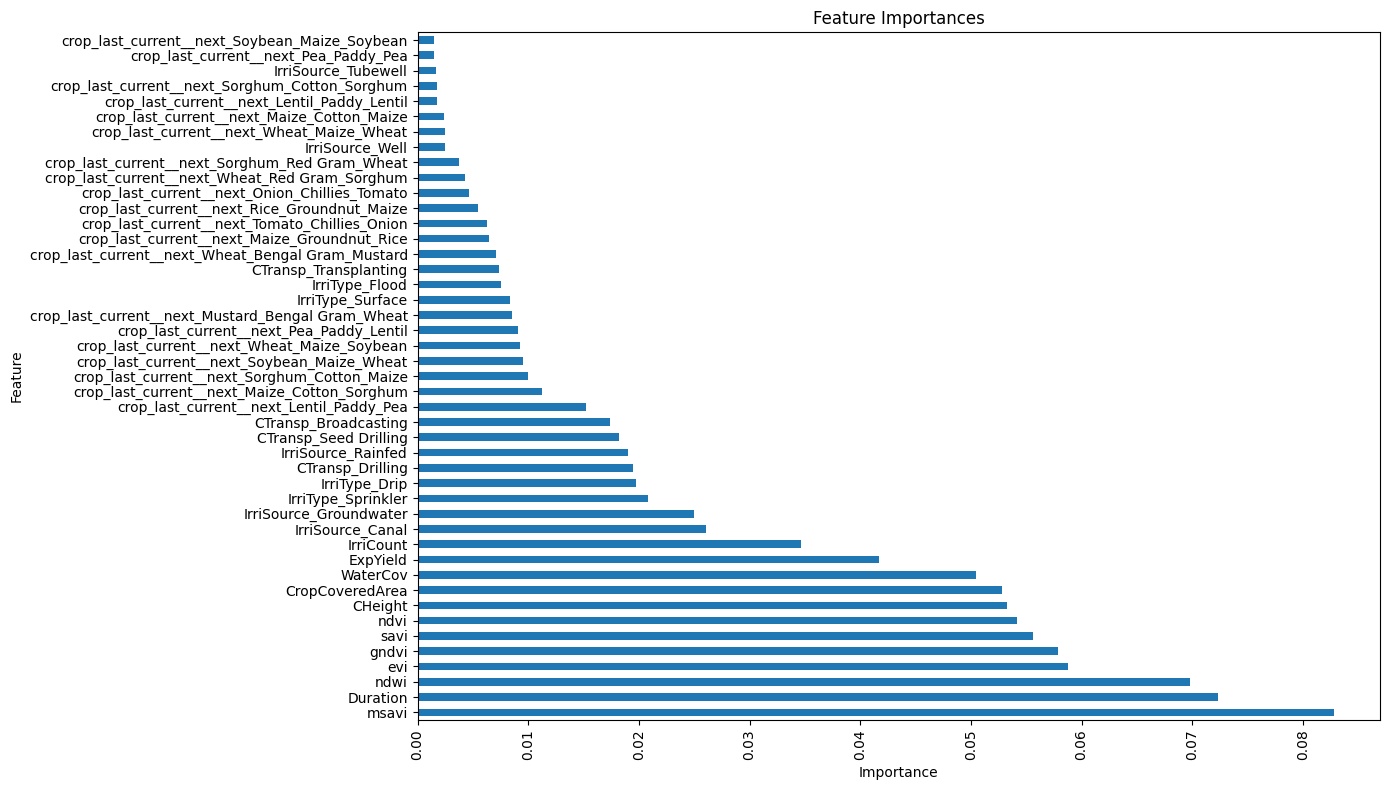

In [426]:
plt.figure(figsize=(14, 8))
feature_importances.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show()

# MLP

In [427]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  
y_test = label_encoder.fit_transform(y_test) 

## 7-layer MLP with Batch Normalization

In [428]:
def create_mlp_with_bn(input_dim, output_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),  
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.3),

        Dense(128),  # Second hidden layer
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        
        Dense(128),  
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        
        Dense(64),  # Fourth hidden layer
        BatchNormalization(),
        tf.keras.layers.ReLU(),

        Dense(64),  
        BatchNormalization(),
        tf.keras.layers.ReLU(),

        Dense(32),  # Sixth hidden layer
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        
        Dense(output_dim, activation='softmax')  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

input_dim = X_train.shape[1]  # Number of features 
output_dim = y_train_encoded.shape[1]  # Number of unique classes 

mlp_model_bn = create_mlp_with_bn(input_dim, output_dim)
history = mlp_model_bn.fit(X_train, y_train_encoded, epochs=60, 
                           batch_size=32, validation_split=0.2,
                           verbose=1)

y_pred_probs_bn = mlp_model_bn.predict(X_test)
y_pred_bn = tf.argmax(y_pred_probs_bn, axis=1).numpy()
f1_bn = f1_score(y_test, y_pred_bn, average='weighted')
print(f"F1 Score (With Batch Norm): {f1_bn}")
print("Classification Report (With Batch Norm):")
print(classification_report(y_test, y_pred_bn))

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3665 - loss: 1.3509 - val_accuracy: 0.5765 - val_loss: 0.9690
Epoch 2/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5486 - loss: 1.0152 - val_accuracy: 0.6293 - val_loss: 0.8771
Epoch 3/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5917 - loss: 0.9383 - val_accuracy: 0.6766 - val_loss: 0.8064
Epoch 4/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6228 - loss: 0.8942 - val_accuracy: 0.6929 - val_loss: 0.7598
Epoch 5/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6434 - loss: 0.8453 - val_accuracy: 0.7085 - val_loss: 0.7253
Epoch 6/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6593 - loss: 0.8162 - val_accuracy: 0.7311 - val_loss: 0.6850
Epoch 7/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6850 - loss: 0.7858 - val_accuracy: 0.7436 - val_loss: 0.6626
Epoch 8/60
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7052 - loss: 0.7387 - val_accuracy: 0.7515 - val_

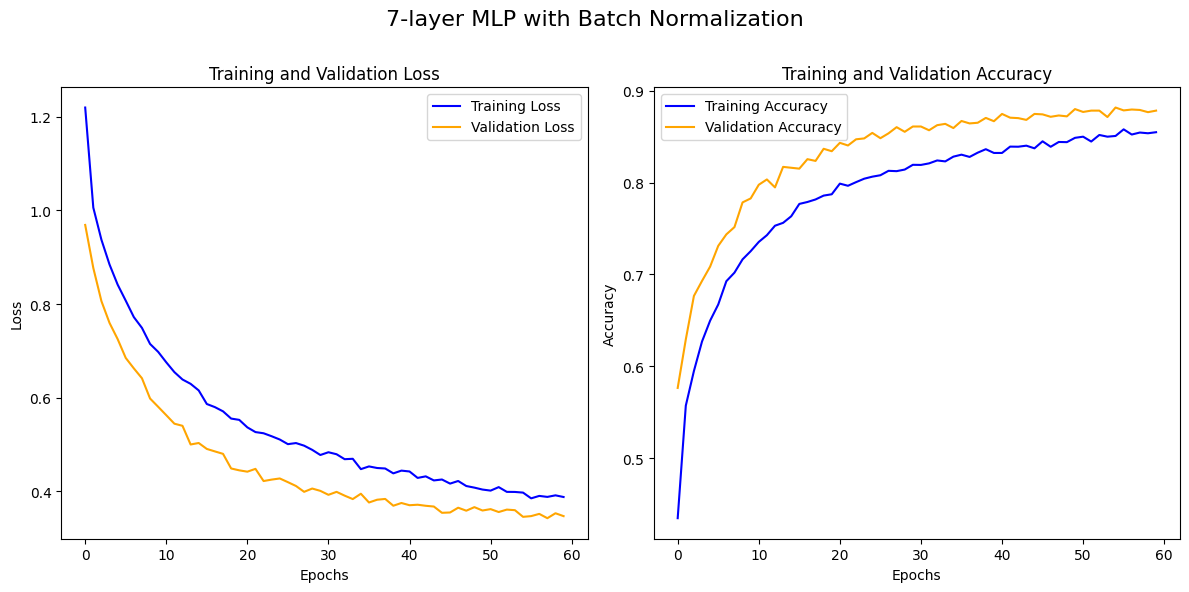

In [429]:
plt.figure(figsize=(12, 6))
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('7-layer MLP with Batch Normalization', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  
plt.show()

# Predicting the 'Submission' file provided by Zindi


In [432]:
submission_probs = mlp_model_bn.predict(submission_features)
submission['Target'] = tf.argmax(submission_probs, axis=1).numpy()

# Convert the predicted numeric labels back to the original categorical labels
submission['Target'] = label_encoder.inverse_transform(submission['Target'])

submission['Target'] = submission['Target'].str.replace('category_', '', regex=False)
final_submission = submission[['FarmID', 'Target']]

final_submission.to_csv('final_submission.csv', index=False)
print("Prediction complete. File saved as 'final_submission.csv'.")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Prediction complete. File saved as 'final_submission.csv'.
